In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
class player(object):
    def __init__(self, num_arm, true_prefer):
        self.num_arm = num_arm
        self.count = np.zeros(num_arm)
        self.prefer = np.zeros(num_arm)
        self.inf = 1000000
        self.ranking = np.ones(num_arm) * self.inf
        self.true_prefer = true_prefer

    def reinit(self):
        self.count = np.zeros(self.num_arm)
        self.prefer = np.zeros(self.num_arm)
        self.ranking = np.ones(self.num_arm) * self.inf

    def update(self, reward, arm_index, round):
        self.count[arm_index] += 1
        self.prefer[arm_index] += 1/self.count[arm_index] * (reward - self.prefer[arm_index])
        self.ranking[arm_index] = self.prefer[arm_index] + np.sqrt(3 * np.log(round) / (2 * self.count[arm_index]))
    
    def rankings(self):
        return np.argsort(-self.ranking)

class player_trueprefer(object):
    def __init__(self, num_arm, true_prefer):
        self.num_arm = num_arm
        self.count = np.zeros(num_arm)
        self.prefer = np.zeros(num_arm)
        self.inf = 1000000
        self.ranking = np.ones(num_arm) * self.inf
        self.true_prefer = true_prefer

    def reinit(self):
        self.count = np.zeros(self.num_arm)
        self.prefer = np.zeros(self.num_arm)
        self.ranking = np.ones(self.num_arm) * self.inf

    def update(self, reward, arm_index, round):
        self.count[arm_index] += 1
        self.prefer[arm_index] += 1/self.count[arm_index] * (reward - self.prefer[arm_index])
        self.ranking[arm_index] = self.prefer[arm_index] + np.sqrt(3 * np.log(round) / (2 * self.count[arm_index]))
    
    def rankings(self):
        return self.true_prefer

In [2]:
class arm(object):
    def __init__(self, num_player, mean, var, ranking):
        self.num_player = num_player
        self.mean = mean
        self.var = var
        self.ranking = ranking

    def rankings(self):
        return self.ranking
    
    def gene_reward(self, player_num):
        return np.random.normal(self.mean[player_num], self.var)

In [35]:
class platform(object):
    def __init__(self, num_players, num_arms):
        self.num_players = num_players
        self.num_arms = num_arms
        self.round = 0 
    
    def update_round(self):
        self.round += 1

    def GS(self, players, arms):
        self.update_round()

        players_to_arms = np.zeros([self.num_players, self.num_arms])
        arms_to_players = np.zeros([self.num_arms, self.num_players])
        for i in range(self.num_players):
            players_to_arms[i] = players[i].rankings()
        for i in range(self.num_arms):
            arms_to_players[i] = arms[i].rankings()
        # trajectory records the proposing, match_or_not record single or not, 
        # match_buffer records all people who propose same arm
        trajectory = np.zeros(self.num_players, int)
        matching_or_not = np.zeros(self.num_players)
        matching_buffer = []
        for i in range(self.num_arms):
            matching_buffer.append([])

        #print(players_to_arms)
        while True:
            if np.sum(matching_or_not) == self.num_players:
                break
            #firstly let all plasyers propose
            for p in range(self.num_players):
                if matching_or_not[p] == 0:
                    p_choice = int(players_to_arms[p][trajectory[p]])
                    matching_buffer[p_choice].append(p)
                    
            #secondly each arm needs to choose the best
            for a in range(len(arms)):
                if len(matching_buffer[a]) != 0:
                    #get the best choice
                    for i in range(self.num_players):
                        flag = False
                        for j in matching_buffer[a]:
                            flag = (arms_to_players[a][i] == j)
                            if flag == True:
                                break
                        if flag == True:
                            a_choice = arms_to_players[a][i]
                            break

                    #update player
                    for p_ in matching_buffer[a]:
                        if p_ == a_choice:
                            matching_or_not[p_] = 1
                        else:
                            matching_or_not[p_] = 0
                            trajectory[p_] += 1

                    #update arm
                    matching_buffer[a] = [int(a_choice)]
        
        #print(players[2].ranking)
        #print(matching_buffer)
        return matching_buffer

    def single_round(self, players, arms):
        matching_buffer = self.GS(players, arms)
        #print(matching_buffer)
        for i, a in enumerate(matching_buffer):
            reward = arms[i].gene_reward(int(a[0]))
            players[int(a[0])].update(reward, i, self.round)
        #print(players[2].ranking)
        return matching_buffer

    def multi_round(self, players, arms, rounds):
        regrets = []
        ranks = np.zeros([rounds, self.num_arms])
        for i in range(self.num_players):
            regrets.append([])

        for i in range(rounds):
            single_match = self.single_round(players, arms)
            ranks[i] = players[2].ranking
            for p in range(len(single_match)):
                optimal_arm = players[p].true_prefer[0] 
                selected_arm = single_match[p][0]
                p_regret = arms[optimal_arm].mean[p] - arms[selected_arm].mean[p]
                regrets[p].append(p_regret)

        regrets = np.cumsum(np.array(regrets), axis=1)
        return regrets, ranks

    def multi_exp(self, players, arms, rounds, exp_times):
        regrets = np.zeros([self.num_players, rounds])
        ranks = np.zeros([rounds, self.num_arms])
        
        for i in range(exp_times):
            _x, _y = self.multi_round(players, arms, rounds)
            regrets += _x / exp_times
            ranks += _y / exp_times
            self.reinit(players)
            players[2].ranking = np.array([2.3,0,0])

        self.plot(regrets)
        self.plot_p3(ranks)
        
    def reinit(self, players):
        self.round = 0
        for i in range(self.num_players):
            players[i].reinit()

    def plot(self, regrets):
        plt.figure(dpi=150)
        plt.plot(regrets[0], color = 'dodgerblue', linewidth = 0.8, label = 'Agent 1')
        plt.plot(regrets[1], color = 'lightskyblue', linewidth = 0.8, label = 'Agent 2')
        plt.plot(regrets[2], color = 'r', linewidth = 0.8, label = 'Agent 3')
        plt.ylabel('Expected Regret')
        plt.xlabel('Time')
        plt.legend()
        #plt.savefig('simulation2.png')

    def plot_p3(self, ranks):
        plt.figure(dpi=150)
        ranks = ranks.transpose((1,0))
        plt.plot(ranks[0], color = 'dodgerblue', linewidth = 0.8, label = 'Arm1')
        plt.plot(ranks[1], color = 'lightskyblue', linewidth = 0.8, label = 'Arm 2')
        plt.plot(ranks[2], color = 'r', linewidth = 0.8, label = 'Arm 3')
        plt.xlabel('Time')
        plt.ylabel('Estimated Mean')
        plt.title('Estimated Mean of Player3 to Each Arm')
        plt.legend()
        #plt.savefig('issue_of_ex6.png')

In [36]:
NUM_PLAYERS = 3
NUM_ARMS = 3
MEAN_ARMS =[[2,1,1.95],[1,2,0],[0,0,2]]
PLAYERS_TO_ARMS_RANKINGS = [[0,1,2], [1,0,2], [2,0,1]]
ARMS_TO_PLAYERS_RANKINGS = [[1,2,0], [0,1,2], [2,0,1]]
players = []
for i in range(NUM_PLAYERS - 1):
    players.append(player_trueprefer(NUM_ARMS, PLAYERS_TO_ARMS_RANKINGS[i]))
players.append(player(NUM_ARMS, PLAYERS_TO_ARMS_RANKINGS[2]))
players[2].ranking = np.array([2.3,0,0])

arms = []
for i in range(NUM_ARMS):
    arms.append(arm(NUM_PLAYERS, MEAN_ARMS[i], 1, ARMS_TO_PLAYERS_RANKINGS[i]))

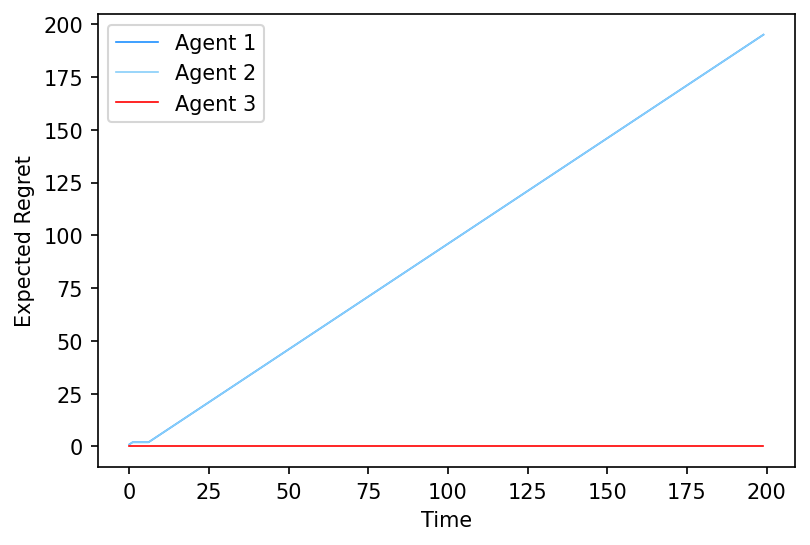

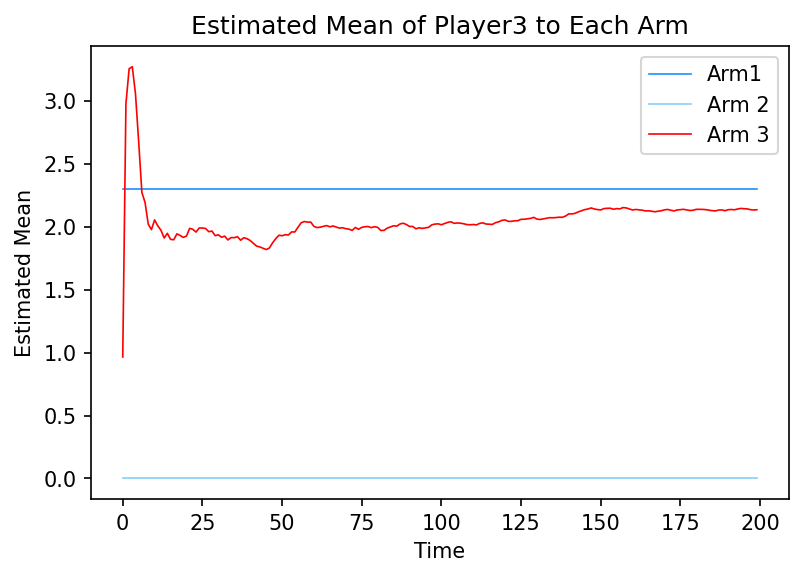

In [37]:
GSplatform = platform(NUM_PLAYERS, NUM_ARMS)
GSplatform.multi_exp(players, arms, 200, 1)

# ex2

In [10]:
class platform(object):
    def __init__(self, num_players, num_arms):
        self.num_players = num_players
        self.num_arms = num_arms
        self.round = 0 
    
    def update_round(self):
        self.round += 1

    def GS(self, players, arms):
        self.update_round()

        players_to_arms = np.zeros([self.num_players, self.num_arms])
        arms_to_players = np.zeros([self.num_arms, self.num_players])
        for i in range(self.num_players):
            players_to_arms[i] = players[i].rankings()
        for i in range(self.num_arms):
            arms_to_players[i] = arms[i].rankings()
        # trajectory records the proposing, match_or_not record single or not, 
        # match_buffer records all people who propose same arm
        trajectory = np.zeros(self.num_players, int)
        matching_or_not = np.zeros(self.num_players)
        matching_buffer = []
        for i in range(self.num_arms):
            matching_buffer.append([])

        #print(players_to_arms)
        while True:
            if np.sum(matching_or_not) == self.num_players:
                break
            #firstly let all plasyers propose
    
            for p in range(self.num_players):
                if matching_or_not[p] == 0:
                    p_choice = int(players_to_arms[p][trajectory[p]])
                    matching_buffer[p_choice].append(p)
            #secondly each arm needs to choose the best
            for a in range(len(arms)):
                if len(matching_buffer[a]) != 0:
                    #get the best choice
                    for i in range(self.num_players):
                        flag = False
                        for j in matching_buffer[a]:
                            flag = (arms_to_players[a][i] == j)
                            if flag == True:
                                break
                        if flag == True:
                            a_choice = arms_to_players[a][i]
                            break

                    #update player
                    for p_ in matching_buffer[a]:
                        if p_ == a_choice:
                            matching_or_not[p_] = 1
                        else:
                            matching_or_not[p_] = 0
                            trajectory[p_] += 1

                    #update arm
                    matching_buffer[a] = [int(a_choice)]
        
        #print(players[2].ranking)
        #print(matching_buffer)
        return matching_buffer

    def single_round(self, players, arms):
        matching_buffer = self.GS(players, arms)
        #print(matching_buffer)
        for i, a in enumerate(matching_buffer):
            reward = arms[i].gene_reward(int(a[0]))
            players[int(a[0])].update(reward, i, self.round)
        #print(players[2].ranking)
        return matching_buffer

    def multi_round(self, players, arms, rounds):
        regrets = []
        for i in range(self.num_players):
            regrets.append([])

        for i in range(rounds):
            single_match = self.single_round(players, arms)
            for p in range(len(single_match)):
                optimal_arm = players[p].true_prefer[0] 
                for a in range(self.num_arms):
                    if single_match[a][0] == p:
                        selected_arm = a
                p_regret = arms[optimal_arm].mean[p] - arms[selected_arm].mean[p]
                regrets[p].append(p_regret)

        regrets = np.cumsum(np.array(regrets), axis=1)
        return regrets

    def multi_exp(self, players, arms, rounds, exp_times):
        regrets = np.zeros([self.num_players, rounds])
        
        for i in range(exp_times):
            _x = self.multi_round(players, arms, rounds)
            regrets += _x / exp_times
            self.reinit(players)
        #print(regrets[0][-1], regrets[1][-1])
        return regrets[0][-1], regrets[1][-1]
        
    def reinit(self, players):
        self.round = 0
        for i in range(self.num_players):
            players[i].reinit()

    def plot(self, regrets):
        plt.figure(dpi=150)
        plt.plot(regrets[0], color = 'dodgerblue', linewidth = 0.8, label = 'Agent 1')
        plt.plot(regrets[1], color = 'r', linewidth = 0.8, label = 'Agent 2')
        plt.ylabel('Expected Regret')
        plt.xlabel('Time')
        plt.legend()
        #plt.savefig('simulation2.png')

    # def plot_p3(self, ranks):
    #     plt.figure(dpi=150)
    #     ranks = ranks.transpose((1,0))
    #     plt.plot(ranks[0], color = 'dodgerblue', linewidth = 0.8, label = 'Arm1')
    #     plt.plot(ranks[1], color = 'r', linewidth = 0.8, label = 'Arm 2')
    #     #plt.plot(ranks[2], color = 'r', linewidth = 0.8, label = 'Arm 3')
    #     plt.xlabel('Time')
    #     plt.ylabel('Estimated Mean')
    #     plt.title('Estimated Mean of Player3 to Each Arm')
    #     plt.legend()
    #     #plt.savefig('issue_of_ex6.png')

In [13]:
DELTA = np.linspace(0.0, 1.0, 20)
NUM_PLAYERS = 2
NUM_ARMS = 2
REGRETS = np.zeros([NUM_PLAYERS, len(DELTA)])
for i in range(len(DELTA)):
    MEAN_ARMS =[[DELTA[i], 0],[0, 1]]
    PLAYERS_TO_ARMS_RANKINGS = [[0,1], [1,0]]
    ARMS_TO_PLAYERS_RANKINGS = [[0,1], [0,1]]
    players = []
    for j in range(NUM_PLAYERS):
        players.append(player(NUM_ARMS, PLAYERS_TO_ARMS_RANKINGS[j]))

    arms = []
    for j in range(NUM_ARMS):
        arms.append(arm(NUM_PLAYERS, MEAN_ARMS[j], 1, ARMS_TO_PLAYERS_RANKINGS[j]))
    GSplatform = platform(NUM_PLAYERS, NUM_ARMS)
    REGRETS[0][i], REGRETS[1][i] = (GSplatform.multi_exp(players, arms, 400, 100))

In [ ]:
plt.figure(dpi=200)
plt.plot(DELTA, REGRETS[0], color = 'dodgerblue', linewidth = 0.8, label = 'Agent 1')
plt.plot(DELTA, REGRETS[1], color = 'r', linewidth = 0.8, label = 'Agent 2')
plt.ylabel('Expected Regret')
plt.xlabel('Reward Gap of Agent 1')
plt.legend()
plt.savefig('simulation1.png')

# Exp 1: 

In [5]:
class player(object):
    def __init__(self, num_arm, true_prefer, UCB = True):
        self.num_arm = num_arm
        self.count = np.zeros(num_arm)
        self.prefer = np.zeros(num_arm)
        self.inf = 1000000
        self.ranking = np.ones(num_arm) * self.inf
        self.true_prefer = true_prefer
        self.UCB = UCB

    def reinit(self):
        self.count = np.zeros(self.num_arm)
        self.prefer = np.zeros(self.num_arm)
        self.ranking = np.ones(self.num_arm) * self.inf

    def update(self, reward, arm_index, round):
        self.count[arm_index] += 1
        self.prefer[arm_index] += 1/self.count[arm_index] * (reward - self.prefer[arm_index])
        self.ranking[arm_index] = self.prefer[arm_index] + np.sqrt(3 * np.log(round) / (2 * self.count[arm_index]))
    
    def rankings(self, ucb = True):
        if ucb:
            return np.argsort(-self.ranking)
        else:
            return np.argsort(-self.prefer)

class platform(object):
    def __init__(self, num_players, num_arms):
        self.num_players = num_players
        self.num_arms = num_arms
        self.round = 0 
    
    def update_round(self):
        self.round += 1

    def GS(self, players, arms, ucb = True):
        self.update_round()

        players_to_arms = np.zeros([self.num_players, self.num_arms])
        arms_to_players = np.zeros([self.num_arms, self.num_players])
        for i in range(self.num_players):
            players_to_arms[i] = players[i].rankings(ucb=ucb)
        for i in range(self.num_arms):
            arms_to_players[i] = arms[i].rankings()
        # trajectory records the proposing, match_or_not record single or not, 
        # match_buffer records all people who propose same arm
        trajectory = np.zeros(self.num_players, int)
        matching_or_not = np.zeros(self.num_players)
        matching_buffer = []
        for i in range(self.num_arms):
            matching_buffer.append([])

        #print(players_to_arms)
        while True:
            if np.sum(matching_or_not) == self.num_players:
                break
            #firstly let all plasyers propose
            for p in range(self.num_players):
                if matching_or_not[p] == 0:
                    p_choice = int(players_to_arms[p][trajectory[p]])
                    matching_buffer[p_choice].append(p)
                    
            #secondly each arm needs to choose the best
            for a in range(len(arms)):
                if len(matching_buffer[a]) != 0:
                    #get the best choice
                    for i in range(self.num_players):
                        flag = False
                        for j in matching_buffer[a]:
                            flag = (arms_to_players[a][i] == j)
                            if flag == True:
                                break
                        if flag == True:
                            a_choice = arms_to_players[a][i]
                            break

                    #update player
                    for p_ in matching_buffer[a]:
                        if p_ == a_choice:
                            matching_or_not[p_] = 1
                        else:
                            matching_or_not[p_] = 0
                            trajectory[p_] += 1

                    #update arm
                    matching_buffer[a] = [int(a_choice)]
        
        #print(players[2].ranking)
        return matching_buffer

    def reinit(self, players):
        self.round = 0
        for i in range(self.num_players):
            players[i].reinit()

    def single_round(self, players, arms):
        matching_buffer = self.GS(players, arms)
        for i, a in enumerate(matching_buffer):
            reward = arms[i].gene_reward(int(a[0]))
            players[int(a[0])].update(reward, i, self.round)

        return matching_buffer

    def multi_round(self, players, arms, rounds):
        regrets = []
        for i in range(self.num_players):
            regrets.append([])

        for i in range(rounds):
            single_match = self.single_round(players, arms)
            for p in range(len(single_match)):
                optimal_arm = players[p].true_prefer[0] 
                for a in range(self.num_arms):
                    if single_match[a][0] == p:
                        selected_arm = a
                p_regret = arms[optimal_arm].mean[p] - arms[selected_arm].mean[p]
                regrets[p].append(p_regret)
        

        regrets = np.cumsum(np.array(regrets), axis=1)
        return regrets

    def multi_round_pessimal(self, players, arms, rounds):
        regrets = []
        for i in range(self.num_players):
            regrets.append([])

        for i in range(rounds):
            single_match = self.single_round(players, arms)
            for p in range(len(single_match)):
                optimal_arm = players[p].true_prefer[-1] 
                for a in range(self.num_arms):
                    if single_match[a][0] == p:
                        selected_arm = a
                p_regret = arms[optimal_arm].mean[p] - arms[selected_arm].mean[p]
                regrets[p].append(p_regret)
        

        regrets = np.cumsum(np.array(regrets), axis=1)
        return regrets

    def multi_exp_pessimal(self, players, arms, rounds, exp_times):
        regrets = np.zeros([self.num_players, rounds])
        
        for i in range(exp_times):
            _x = self.multi_round_pessimal(players, arms, rounds)
            regrets += _x / exp_times
            self.reinit(players)
        return regrets

    def multi_exp(self, players, arms, rounds, exp_times):
        regrets = np.zeros([self.num_players, rounds])
        
        for i in range(exp_times):
            _x = self.multi_round(players, arms, rounds)
            regrets += _x / exp_times
            self.reinit(players)
        return regrets

    def single_etc(self, players, arms, h, rounds):
        regrets = []
        for i in range(self.num_players):
            regrets.append([]) 

        for t in range(rounds):
            if t < h * self.num_arms:
                for i in range(self.num_players):
                    index = ((t + i) % self.num_arms)
                    reward = arms[index].gene_reward(i)
                    players[i].update(reward, index, self.round)
                    #compute regret
                    optimal_arm = players[i].true_prefer[0] 
                    selected_arm = index
                    p_regret = arms[optimal_arm].mean[i] - arms[selected_arm].mean[i]
                    regrets[i].append(p_regret)
            else:
                if t == h * self.num_arms:
                    single_match = self.GS(players, arms, ucb=False)
                for p in range(len(single_match)):
                    optimal_arm = players[p].true_prefer[0] 
                    for a in range(self.num_arms):
                        if single_match[a][0] == p:
                            selected_arm = a
                    p_regret = arms[optimal_arm].mean[p] - arms[selected_arm].mean[p]
                    regrets[p].append(p_regret)
            #print(players[0].rankings(False))
        
        regrets = np.cumsum(np.array(regrets), axis=1)
        return regrets
        
    def multi_etc(self, players, arms, h, rounds, trails = 1):
        regrets = np.zeros([self.num_players, rounds])
        
        for i in range(trails):
            _x = self.single_etc(players, arms, h, rounds)
            regrets += _x / trails
            self.reinit(players)
        return regrets

    
    def single_dec_etc(self, players, arms, h, rounds):
        regrets = []
        for i in range(self.num_players):
            regrets.append([]) 
        

class exp(object):
    def __init__(self, num_players, num_arms, players, arms, UCB = True):
        self.num_players = num_players
        self.num_arms = num_arms
        self.players = players
        self.arms = arms
        self.platform = platform(num_players, num_arms)
        self.UCB = UCB

    def exp1(self, rounds = 4000, trails = 1, h = [25, 50 ,75, 100, 125, 150]):
        regrets_ucb = self.platform.multi_exp(self.players, self.arms, rounds, trails)
        #regrets_ucb_pess = self.platform.multi_exp_pessimal(self.players, self.arms, rounds, trails)
        etcs = []
        for _h in h:
            etcs.append(self.platform.multi_etc(self.players, self.arms, _h, rounds, trails))
        return regrets_ucb, etcs

    def exp2(self, rounds = 4000, trails = 10):
        regrets_ucb = self.platform.multi_exp(self.players, self.arms, rounds, trails)
        regrets_ucb_pess = self.platform.multi_exp_pessimal(self.players, self.arms, rounds, trails)
        return regrets_ucb, regrets_ucb_pess

In [11]:
NUM_PLAYERS = 10
NUM_ARMS = 10
MEAN_ARMS = np.linspace(0.9, 0, NUM_ARMS)
PLAYERS_TO_ARMS_RANKINGS = np.arange(NUM_ARMS)
ARMS_TO_PLAYERS_RANKINGS = np.arange(NUM_PLAYERS)
players = []
for j in range(NUM_PLAYERS):
    players.append(player(NUM_ARMS, PLAYERS_TO_ARMS_RANKINGS))

arms = []
for j in range(NUM_ARMS):
    arms.append(arm(NUM_PLAYERS, MEAN_ARMS[j] * np.ones(NUM_PLAYERS), 1, ARMS_TO_PLAYERS_RANKINGS))

exp_1 = exp(NUM_PLAYERS, NUM_ARMS, players, arms)
h = [25, 50, 100, 200, 400]
ucb, etcs = exp_1.exp1(rounds = 8000, trails = 10, h = h)

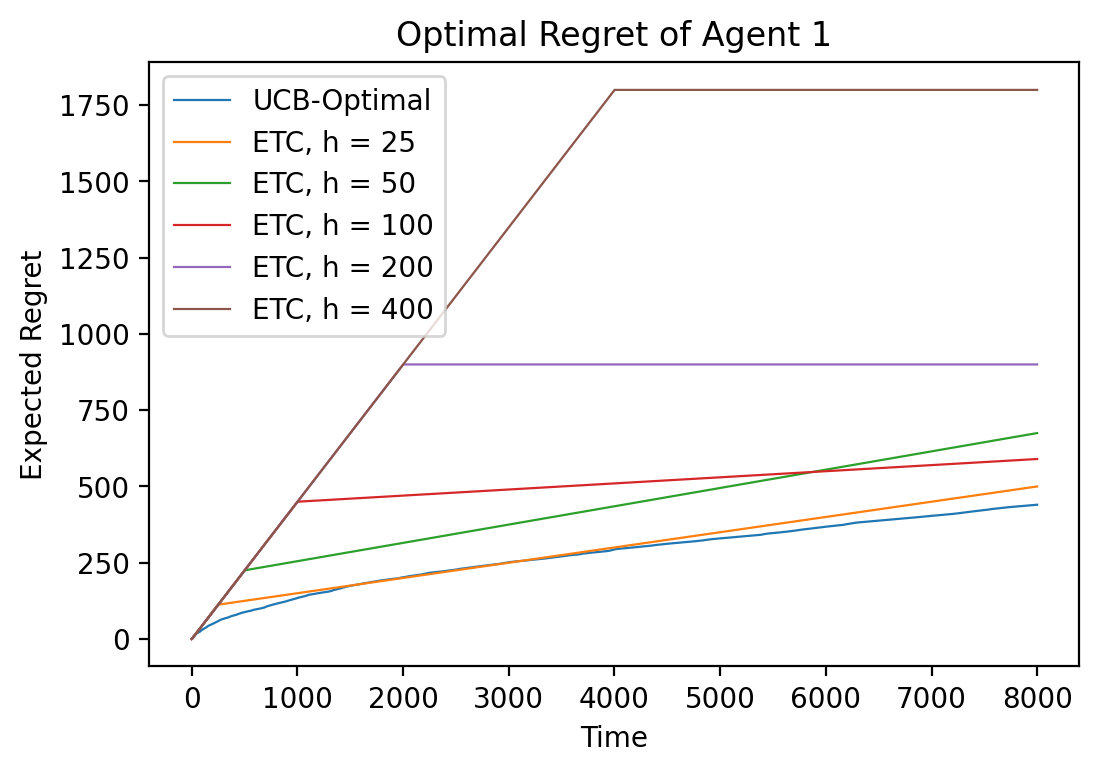

In [14]:
plt.figure(dpi = 200)
plt.plot(ucb[0], linewidth = 0.8, label = 'UCB-Optimal')
for i, _h in enumerate(h):
    plt.plot(etcs[i][0], linewidth = 0.8, label = 'ETC, h = ' + str(_h))
plt.legend()
plt.xlabel('Time')
plt.ylabel('Expected Regret')
plt.title("Optimal Regret of Agent 1")
plt.savefig('simulation3.png')

# Exp 2: More pairs

In [6]:
NUM_PLAYERS = 20
NUM_ARMS = 20
MEAN_ARMS = np.linspace(1.9, 0, NUM_ARMS)
PLAYERS_TO_ARMS_RANKINGS = np.arange(NUM_ARMS)
ARMS_TO_PLAYERS_RANKINGS = np.arange(NUM_PLAYERS)
players = []
for j in range(NUM_PLAYERS):
    players.append(player(NUM_ARMS, PLAYERS_TO_ARMS_RANKINGS))

arms = []
for j in range(NUM_ARMS):
    arms.append(arm(NUM_PLAYERS, MEAN_ARMS[j] * np.ones(NUM_PLAYERS), 1, ARMS_TO_PLAYERS_RANKINGS))
exp_2 = exp(NUM_PLAYERS, NUM_ARMS, players, arms)
h = [25, 50, 100, 200, 400]
exp2_ucb, exp2_etcs = exp_2.exp1(rounds = 8000, trails = 10, h = h)

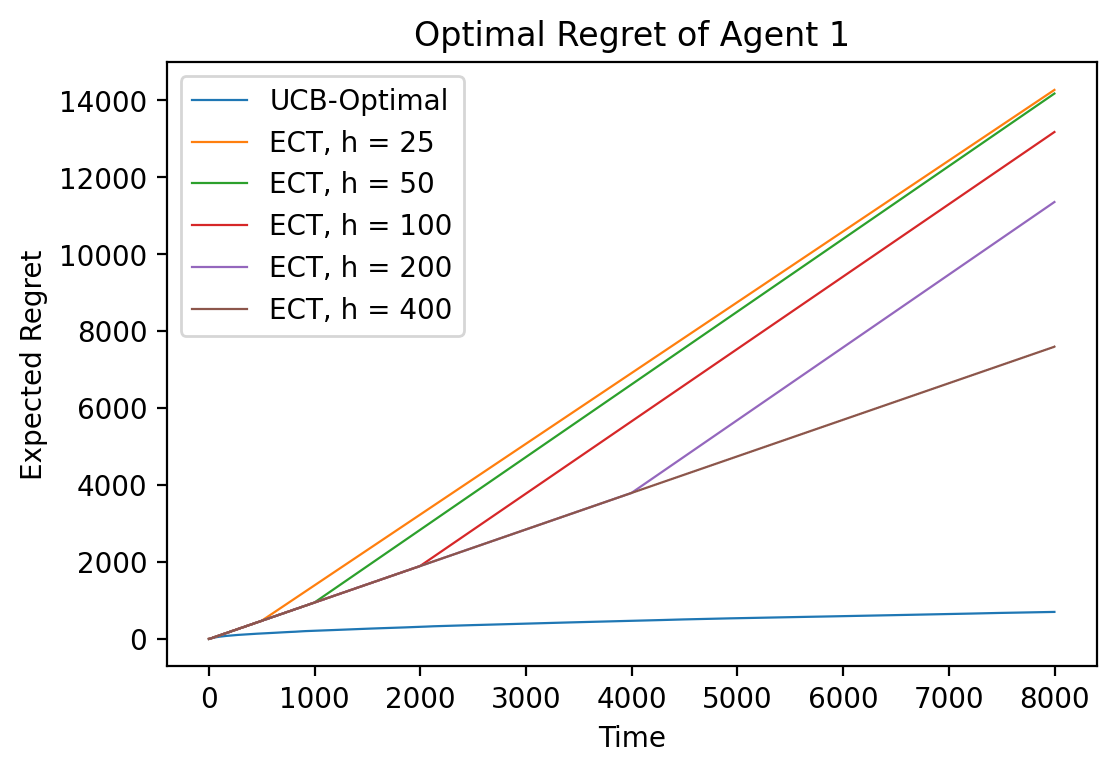

In [15]:
plt.figure(dpi = 200)
plt.plot(exp2_ucb[0], linewidth = 0.8, label = 'UCB-Optimal')
for i, _h in enumerate(h):
    plt.plot(exp2_etcs[i][19], linewidth = 0.8, label = 'ECT, h = ' + str(_h))
plt.legend()
plt.xlabel('Time')
plt.ylabel('Expected Regret')
plt.title("Optimal Regret of Agent 1")
plt.savefig('simulation4-20.png')

# Centralized vs Decentralized